In [5]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
import time
import datetime
import json

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import max
from pyspark.sql.functions import col
from pyspark.sql.functions import count
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import min
from pyspark.sql.functions import mean
from pyspark.sql.functions import countDistinct
#from pyspark.sql.functions import *
from pyspark.sql import Window

from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler, VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, NaiveBayes, RandomForestClassifier, OneVsRest
from pyspark.ml.classification import LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.regression import GBTRegressor
from pyspark.ml import Pipeline

sns.set()
# magic word for producing visualizations in notebook
%matplotlib inline

In [6]:
spark.conf.get("spark.sql.shuffle.partitions")

'4'

In [7]:

spark.conf.set("spark.sql.shuffle.partitions", 4)
spark.conf.get("spark.sql.shuffle.partitions")

'4'

In [8]:
# The code was removed by Watson Studio for sharing.

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [9]:
#user_log = df_data_2
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [10]:
user_log.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

In [11]:
user_log.show(n=1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+---------

In [12]:
user_log.take(5)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [13]:
user_log.describe("sessionID").show()

+-------+------------------+
|summary|         sessionID|
+-------+------------------+
|  count|            543705|
|   mean|2040.8143533717732|
| stddev| 1434.338931078271|
|    min|                 1|
|    max|              4808|
+-------+------------------+



In [14]:
user_log.count()

543705

In [15]:
user_log.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [16]:
user_log.toPandas().isnull().sum()

artist           110828
auth                  0
firstName         15700
gender            15700
itemInSession         0
lastName          15700
length           110828
level                 0
location          15700
method                0
page                  0
registration      15700
sessionId             0
song             110828
status                0
ts                    0
userAgent         15700
userId                0
dtype: int64

In [17]:
user_log_valid = user_log.dropna(how = "any", subset=["userID", "sessionID"])

In [18]:
user_log_valid.count()

543705

### no rows where deleted -> there were no missing values vor userID and sessionID

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [19]:
user_log_valid.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [20]:
user_log_valid.select('userId').dropDuplicates().count()

449

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.


In [21]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)


In [22]:
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [23]:
user_log_valid = user_log_valid.withColumn("churn", flag_cancellation_event("page"))

In [24]:
user_log_valid = user_log_valid.withColumn("churn", Fsum("churn").over(windowval))

In [25]:
user_log_valid.head()

Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=26, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=4438, song=None, status=200, ts=1543622159000, userAgent=None, userId='', churn=0)

In [26]:
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [27]:
user_log_valid = user_log_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [28]:
user_log_valid.head(5)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=26, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=4438, song=None, status=200, ts=1543622159000, userAgent=None, userId='', churn=0, downgraded=0),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=20, lastName=None, length=None, level='paid', location=None, method='PUT', page='Login', registration=None, sessionId=4669, song=None, status=307, ts=1543622152000, userAgent=None, userId='', churn=0, downgraded=0),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=19, lastName=None, length=None, level='paid', location=None, method='GET', page='Home', registration=None, sessionId=4669, song=None, status=200, ts=1543622151000, userAgent=None, userId='', churn=0, downgraded=0),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=15, lastName=None, length=None, le

In [29]:
user_log_valid = user_log_valid.withColumn("phase_down", Fsum("downgraded").over(windowval))

In [30]:
user_log_valid.describe('churn').show()

+-------+------------------+
|summary|             churn|
+-------+------------------+
|  count|            543705|
|   mean|0.1906291095355018|
| stddev|0.3927975762505338|
|    min|                 0|
|    max|                 1|
+-------+------------------+



### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [31]:
user_log_valid.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   99|
|    0|  350|
+-----+-----+



### Calculating by Weekday

In [32]:
weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [33]:
user_log_valid = user_log_valid.withColumn("weekday", weekday(user_log_valid.ts))

In [34]:
df_tmp = user_log_valid.filter(user_log_valid.page == "NextSong").groupby(user_log_valid.weekday).count().orderBy(user_log_valid.weekday.cast("int"))

In [35]:
df_tmp = df_tmp.toPandas()

In [36]:
df_tmp.weekday = pd.to_numeric(df_tmp.weekday)

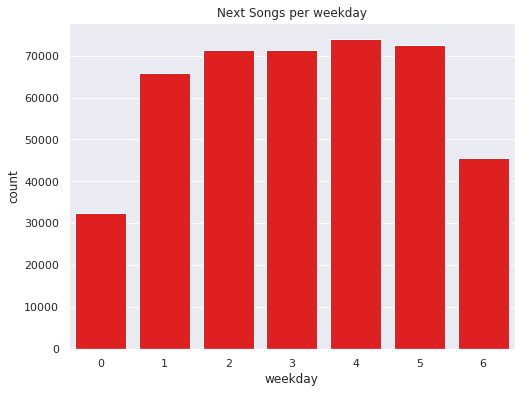

In [37]:
plt.figure(figsize = [8,6])
sns.barplot(data=df_tmp, x='weekday', y='count', color='red').set_title('Next Songs per weekday');

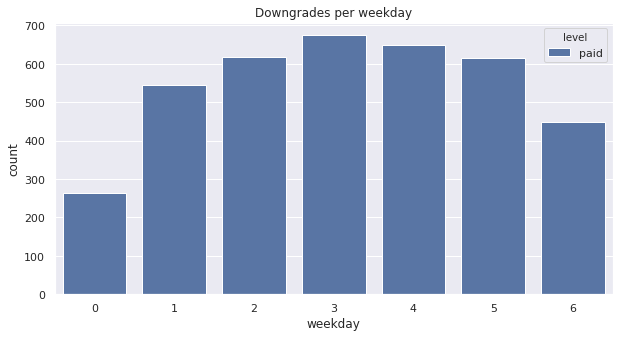

In [38]:
df_tmp = user_log_valid.filter(user_log_valid.page == "Downgrade").groupby([user_log_valid.weekday, user_log_valid.level]).count().orderBy(user_log_valid.weekday.cast("int"))
df_tmp = df_tmp.toPandas()
df_tmp.weekday = pd.to_numeric(df_tmp.weekday)
plt.figure(figsize = [10,5])
sns.barplot(data=df_tmp, x='weekday', y='count', hue='level').set_title('Downgrades per weekday');

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Feature: unique user, gender, registration, number of actions

In [39]:
df_feat = 0
df_feat = user_log_valid.groupby(['userId', 'gender', 'registration','churn']).agg(count('userID').alias('num_actions'))

In [40]:
df_feat = df_feat.withColumn('gender', regexp_replace('gender', 'F', '1'))
df_feat = df_feat.withColumn('gender', regexp_replace('gender', 'M', '0'))

In [41]:
df_feat.show()

+------+------+-------------+-----+-----------+
|userId|gender| registration|churn|num_actions|
+------+------+-------------+-----+-----------+
|100002|     1|1529934689000|    0|        177|
|100010|     1|1538016340000|    1|        137|
|100015|     1|1537208989000|    0|        529|
|100018|     0|1533812833000|    1|        169|
|100023|     0|1536679150000|    1|        174|
|100028|     1|1537449535000|    1|        707|
|100039|     0|1534359786000|    0|        148|
|100042|     1|1538322861000|    1|        377|
|   102|     0|1537915702000|    0|        163|
|   107|     1|1536303841000|    0|        779|
|   110|     0|1537665002000|    0|        525|
|   111|     1|1536372490000|    0|        129|
|   120|     1|1532472246000|    1|       1513|
|   130|     0|1533575236000|    1|        364|
|   135|     1|1532433959000|    0|        138|
|   137|     0|1532450666000|    0|         53|
|   139|     0|1535271638000|    0|        330|
|   146|     0|1536138073000|    0|     

In [42]:
df_feat.count()

449

### Feature: number of downgrades

In [43]:
num_downgrades_df = user_log_valid.groupBy('userId').agg(count('downgraded').alias('num_downgrades'))
df_feat = num_downgrades_df.join(df_feat, on='userId', how='right')

### Feature: length of stay on platform

In [44]:
days_reg_df = user_log_valid.groupBy('userID').agg(max('ts').alias('last_interaction'))
df_feat = days_reg_df.join(df_feat, on='userID').withColumn('days_registered', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))

### Feature: sum and average session lenght

In [45]:
avg_ses = user_log_valid.groupBy(['userID', 'sessionID']).agg(min('ts').alias('first_action'), max('ts').alias('last_action'))

In [46]:
df_tmp = avg_ses.withColumn('session_time_min', ((col('last_action')-col('first_action'))/1440000).cast(IntegerType()))
df_clean = df_tmp.groupBy('userID').agg(mean('session_time_min').alias('avg_session_time_min'))
df_clean.show()

+------+--------------------+
|userID|avg_session_time_min|
+------+--------------------+
|   179|                18.4|
|      |  249.02374920835973|
|    85|            11.53125|
|   291|  7.1923076923076925|
|    80|   9.578947368421053|
|   226|                14.0|
|    65|  11.185185185185185|
|   130|   6.428571428571429|
|   235|                 8.7|
|   225|  17.772727272727273|
|   260|  14.222222222222221|
|   157|               20.85|
|    74|  16.166666666666668|
|   275|   6.176470588235294|
|   279|   8.777777777777779|
|   146|                 8.0|
|   250|  17.391304347826086|
|   159|   4.166666666666667|
|   212|  15.272727272727273|
|   135|                 3.5|
+------+--------------------+
only showing top 20 rows



In [47]:
df_feat = df_clean.join(df_feat, on='userID', how='right')
df_feat.show()

+------+--------------------+----------------+--------------+------+-------------+-----+-----------+---------------+
|userID|avg_session_time_min|last_interaction|num_downgrades|gender| registration|churn|num_actions|days_registered|
+------+--------------------+----------------+--------------+------+-------------+-----+-----------+---------------+
|      |  249.02374920835973|   1543622159000|         15700|  null|         null|    0|      15700|           null|
|100002|                5.75|   1541146660000|           177|     1|1529934689000|    0|        177|            129|
|100010|                 8.5|   1539254318000|           137|     1|1538016340000|    1|        137|             14|
|100015|   4.769230769230769|   1543622248000|           529|     1|1537208989000|    0|        529|             74|
|100018|                10.0|   1538969039000|           169|     0|1533812833000|    1|        169|             59|
|100023|                12.0|   1538797185000|           174|   

In [48]:
df_tmp_2 = df_tmp.groupby('userId').agg(Fsum('session_time_min').alias('sum_session_time_min'))
df_feat = df_tmp_2.join(df_feat, on='userId', how='right')

### Feature: number and average of songs per session

In [49]:
song_df = user_log_valid.filter(user_log_valid.page == 'NextSong').groupby(['userID', 'sessionID']).agg(count('page').alias('songs_per_session'))
df_tmp = song_df.groupby('userID').agg(mean('songs_per_session').alias('avg_songs_per_session'))
df_feat = df_tmp.join(df_feat, on='userID', how='right')

In [50]:
df_tmp = song_df.groupby('userID').agg(Fsum('songs_per_session').alias('sum_songs_per_session'))

In [51]:
df_feat = df_tmp.join(df_feat, on='userID', how='right')

### Feature: number of sessions

In [52]:
num_ses_df = user_log_valid.groupBy(['userID']).agg(countDistinct('sessionID').alias('num_session'))
df_feat = num_ses_df.join(df_feat, on='userID', how='right')

In [53]:
df = df_feat.toPandas()

In [54]:
columns=df.isna().sum()
frame={'attribute': columns.index, 'sum_nan': columns.values}
df_test=pd.DataFrame(frame)
df_test['percent']=np.round(100*df_test['sum_nan']/(df.shape[0]),2)
df_test.sort_values('percent', ascending=False, inplace=True)
df_test.head(10)

,attribute,sum_nan,percent
2,sum_songs_per_session,1,0.22
3,avg_songs_per_session,1,0.22
8,gender,1,0.22
9,registration,1,0.22
12,days_registered,1,0.22
0,userID,0,0.00
1,num_session,0,0.00
4,sum_session_time_min,0,0.00
5,avg_session_time_min,0,0.00
6,last_interaction,0,0.00


In [55]:
df_feat = df_feat.na.fill(0)

In [56]:
df = df_feat.toPandas()
columns=df.isna().sum()
frame={'attribute': columns.index, 'sum_nan': columns.values}
df_test=pd.DataFrame(frame)
df_test['percent']=np.round(100*df_test['sum_nan']/(df.shape[0]),2)
df_test.sort_values('percent', ascending=False, inplace=True)
df_test.head(10)

,attribute,sum_nan,percent
8,gender,1,0.22
0,userID,0,0.00
1,num_session,0,0.00
2,sum_songs_per_session,0,0.00
3,avg_songs_per_session,0,0.00
4,sum_session_time_min,0,0.00
5,avg_session_time_min,0,0.00
6,last_interaction,0,0.00
7,num_downgrades,0,0.00
9,registration,0,0.00


/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


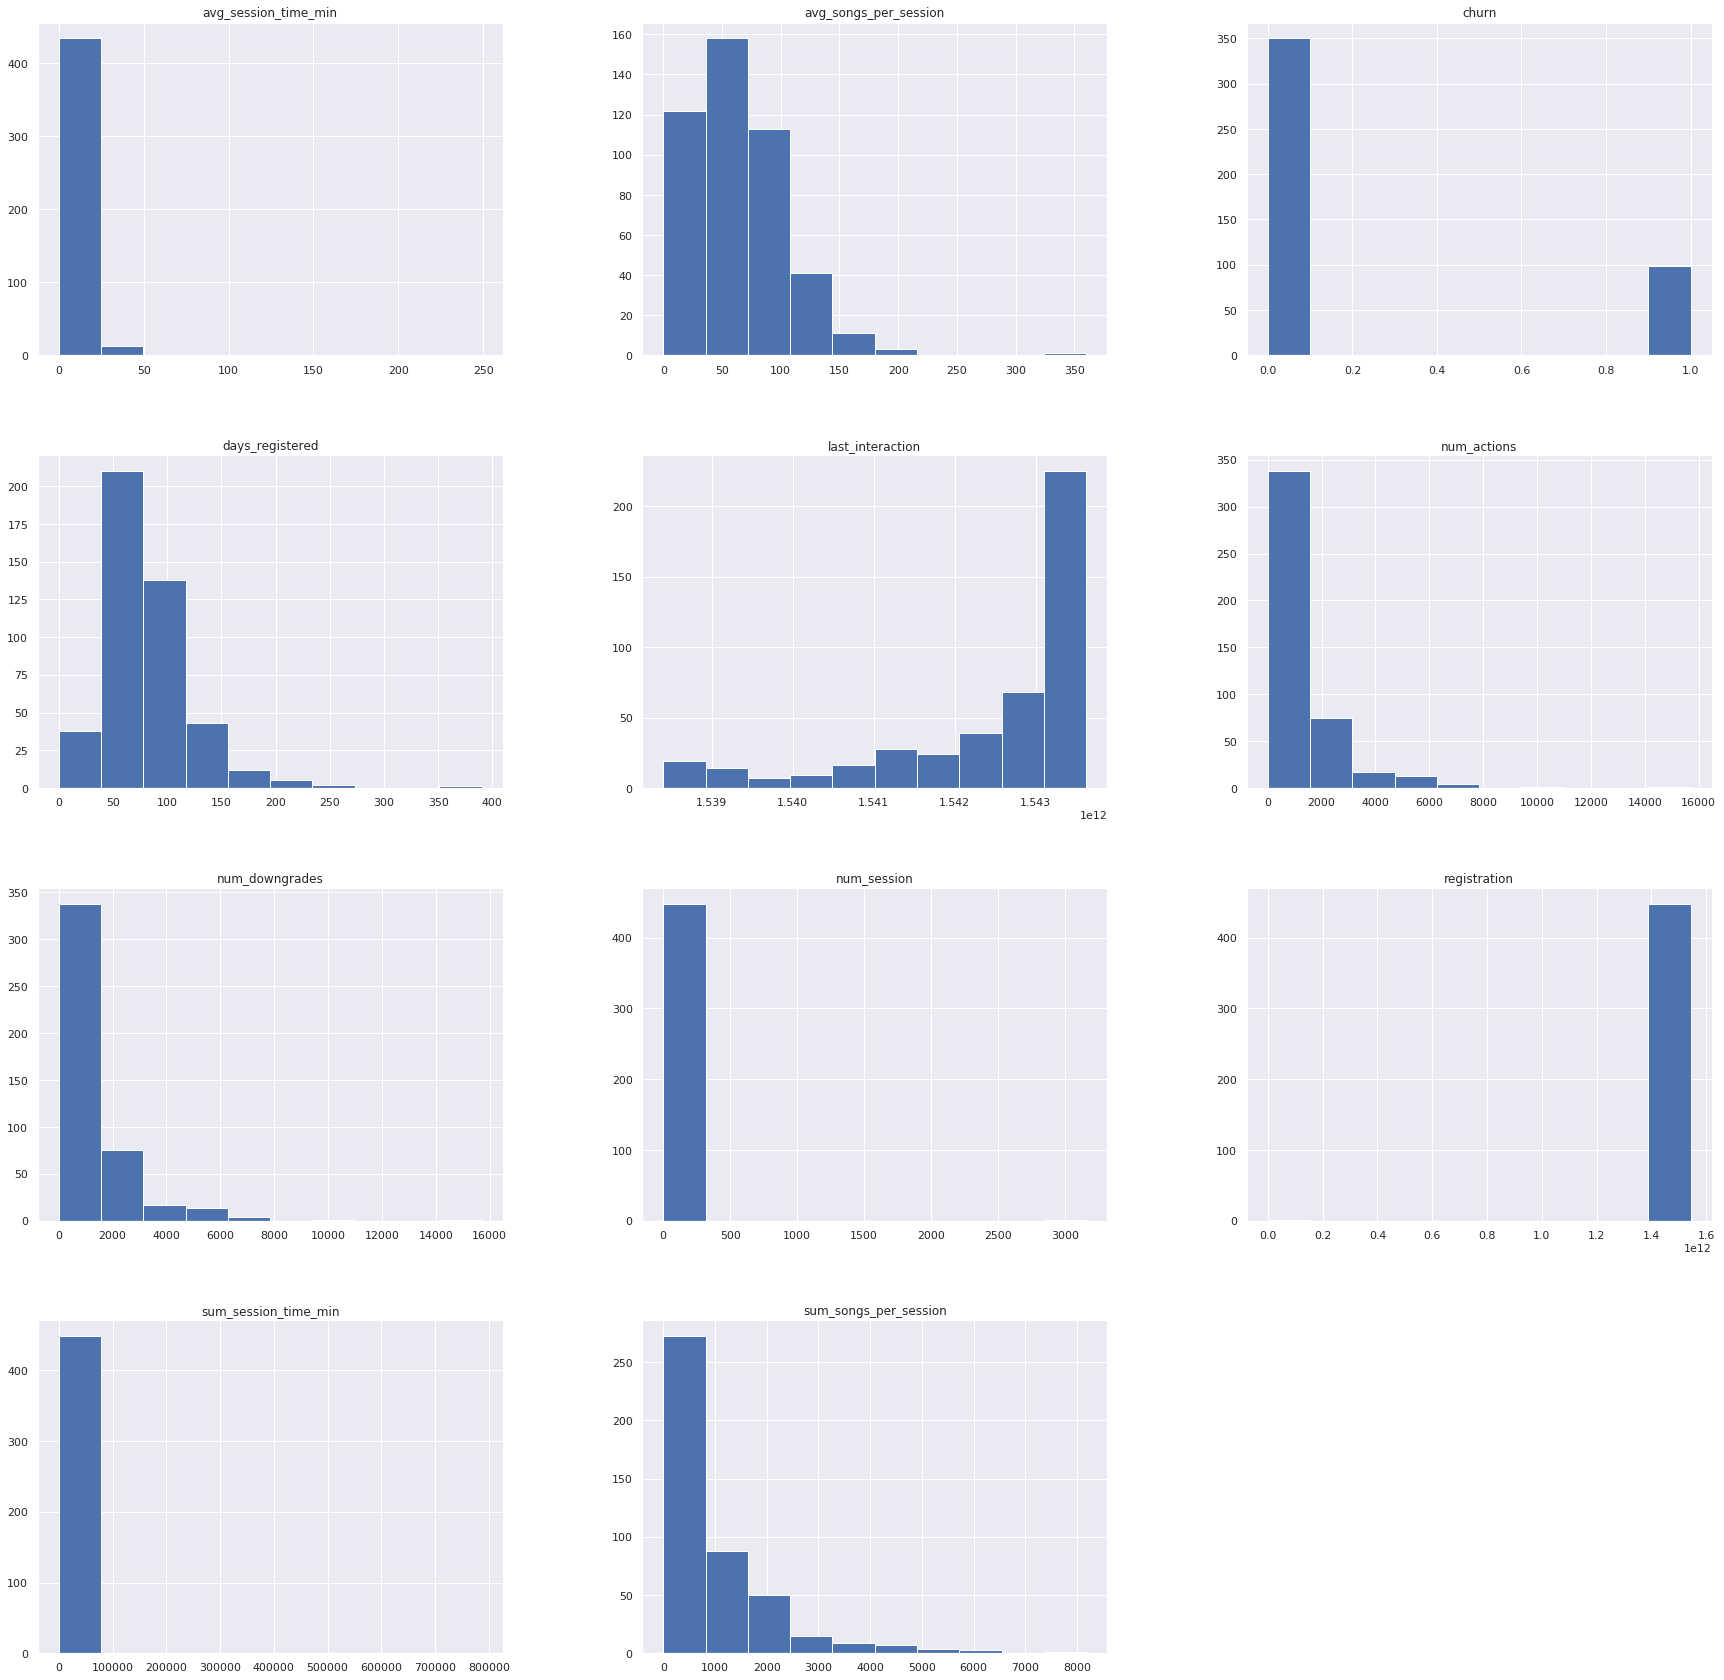

In [57]:
fig = plt.figure(figsize = (30,30))
ax = fig.gca()
df.hist(ax = ax);

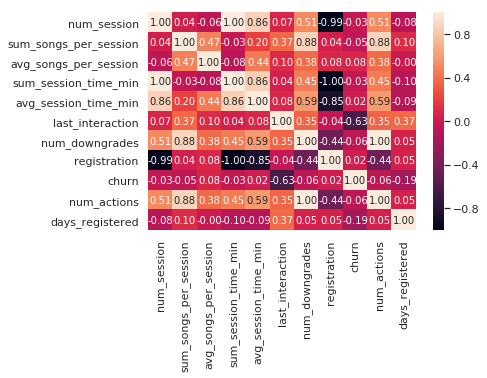

In [58]:
sns.heatmap(df.corr(), annot=True, fmt='.2f');

In [59]:
df_mod = df_feat

### cast features

In [60]:
col_int = ['num_session', 'sum_songs_per_session', 'sum_session_time_min', 'num_downgrades',  'gender', 'churn', 'num_actions']
col_float = ['avg_songs_per_session', 'avg_session_time_min']
col_long = ['days_registered', 'last_interaction']

In [61]:
for column in col_int:
    df_mod = df_mod.withColumn(column, df_mod[column].cast(IntegerType()))
    
for column in col_float:
    df_mod = df_mod.withColumn(column, df_mod[column].cast('float'))

for column in col_long:
    df_mod = df_mod.withColumn(column, df_mod[column].cast('long'))

In [62]:
df_mod.printSchema()

root
 |-- userID: string (nullable = true)
 |-- num_session: integer (nullable = true)
 |-- sum_songs_per_session: integer (nullable = true)
 |-- avg_songs_per_session: float (nullable = false)
 |-- sum_session_time_min: integer (nullable = true)
 |-- avg_session_time_min: float (nullable = false)
 |-- last_interaction: long (nullable = true)
 |-- num_downgrades: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- registration: long (nullable = true)
 |-- churn: integer (nullable = true)
 |-- num_actions: integer (nullable = false)
 |-- days_registered: long (nullable = true)



In [63]:
df_mod = df_mod.na.fill(0)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# VectorAssembler

In [64]:
cols = col_int + col_float
cols.remove('churn')

In [65]:
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
df_vec = assembler.transform(df_mod)

# Scale the Vectors

In [66]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledFeatures", withStd=True)
scalerModel = scaler.fit(df_vec)
df_scaled = scalerModel.transform(df_vec)

# DF for ML

In [67]:
df_ml = df_scaled.select(df_scaled.churn.alias('label'), df_scaled.ScaledFeatures.alias('features'))

In [68]:
# Train Test split

In [69]:
train, test = df_ml.randomSplit([0.8, 0.2], seed=42)

# Modelling

In [70]:
def evaluate_model(model, train, test, train_time):
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    
    predictions_train = model.transform(train).select("features", "label", "prediction")
    predictions_train = predictions_train.select(col("label").cast("Float"),col("prediction"))
    predictions_test = model.transform(test).select("features", "label", "prediction")
    predictions_test = predictions_test.select(col("label").cast("Float"),col("prediction"))
    
    # accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy_train = evaluator.evaluate(predictions_train)
    accuracy_test = evaluator.evaluate(predictions_test)
    
    # f1
    evaluatorf1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1 = evaluatorf1.evaluate(predictions_test)

    results={}
    results['accuracy_train']=accuracy_train
    results['accuracy_test']=accuracy_test
    results['f1']=f1
    results['fitting_time']=train_time
    
    print("Accuracy training: %g" %accuracy_train)
    print("Accuracy test: %g" %accuracy_test)
    print("f1: %g" %f1)
    print("")
    print("")
    
    return(results)

In [71]:
lr = LogisticRegression()
results={}
model_list=['LogisticRegression()','RandomForestClassifier()', 'DecisionTreeClassifier()', 'NaiveBayes()', 'OneVsRest(classifier=lr)']
#model_list=['NaiveBayes()']
for model in model_list:
    print('Training model: ' + model)
    start_time = time.time()
    model_type = eval(model)
    model_fitted = model_type.fit(train)
    end_time = time.time()
    duration = end_time-start_time
    
    a = datetime.timedelta(seconds=int(duration))
    print("Training time: {}".format(str(a)))
    print("")
    results[model] = evaluate_model(model_fitted, train, test, duration)
    

Training model: LogisticRegression()
Training time: 0:00:43

Accuracy training: 0.776536
Accuracy test: 0.813187
f1: 0.729404


Training model: RandomForestClassifier()
Training time: 0:01:12

Accuracy training: 0.798883
Accuracy test: 0.791209
f1: 0.735012


Training model: DecisionTreeClassifier()
Training time: 0:00:54

Accuracy training: 0.790503
Accuracy test: 0.813187
f1: 0.729404


Training model: NaiveBayes()
Training time: 0:00:54

Accuracy training: 0.776536
Accuracy test: 0.813187
f1: 0.729404


Training model: OneVsRest(classifier=lr)
Training time: 0:01:35

Accuracy training: 0.776536
Accuracy test: 0.813187
f1: 0.729404




# Tuning LogisticRegression

In [72]:
model = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(model.regParam,[0.01, 0.1, 1]) \
    .addGrid(model.elasticNetParam,[0.0, 0.5, 1]) \
    .addGrid(model.aggregationDepth,[2, 5]) \
    .build()

model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,evaluator=MulticlassClassificationEvaluator(),numFolds=3, seed=42, parallelism=10)

start_time = time.time()
print('Start fitting..')
fitted_model = model_evaluator.fit(train)
duration = time.time()-start_time
print(f'Done in {str(datetime.timedelta(seconds=int(duration)))}')
bestModel = fitted_model.bestModel
print('Details:')
print('regParam - ', bestModel.getOrDefault('regParam'))
print('elasticNetParam - ', bestModel.getOrDefault('elasticNetParam'))
print('aggregationDepth - ', bestModel.getOrDefault('aggregationDepth'))

Start fitting..
Done in 0:04:48
Details:
regParam -  0.01
elasticNetParam -  0.0
aggregationDepth -  2


In [73]:
evaluate_model(fitted_model, train, test, duration)

Accuracy training: 0.773743
Accuracy test: 0.813187
f1: 0.729404




{'accuracy_train': 0.7737430167597765,
 'accuracy_test': 0.8131868131868132,
 'f1': 0.7294039294039294,
 'fitting_time': 288.5200123786926}

# Tuning RandomForestClassifier

In [74]:
model = RandomForestClassifier()
param_grid = ParamGridBuilder() \
    .addGrid(model.maxDepth,[10, 20, 30]) \
    .addGrid(model.impurity,['entropy', 'gini']) \
    .addGrid(model.maxBins,[5, 10]) \
    .addGrid(model.numTrees,[15, 25, 30]) \
    .build()

model_evaluator = CrossValidator(estimator=model, estimatorParamMaps=param_grid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3, seed=42, parallelism=10)


start_time = time.time()
print('Start fitting..')
fitted_model = model_evaluator.fit(train)
duration = time.time()-start_time
print(f'Done in {str(datetime.timedelta(seconds=int(duration)))}')
bestModel = fitted_model.bestModel
print('Details:')
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))
print('impurity - ', bestModel.getOrDefault('impurity'))
print('maxBins - ', bestModel.getOrDefault('maxBins'))
print('numTrees - ', bestModel.getOrDefault('numTrees'))
print('featureSubsetStrategy - ', bestModel.getOrDefault('featureSubsetStrategy'))

Start fitting..
Done in 0:07:14
Details:
maxDepth -  10
impurity -  gini
maxBins -  10
numTrees -  25
featureSubsetStrategy -  auto


In [75]:
evaluate_model(fitted_model, train, test, duration)

Accuracy training: 0.885475
Accuracy test: 0.802198
f1: 0.776839




{'accuracy_train': 0.8854748603351955,
 'accuracy_test': 0.8021978021978022,
 'f1': 0.7768385460693153,
 'fitting_time': 434.6531300544739}

In [76]:
evaluate_model(bestModel, train, test, duration)

Accuracy training: 0.885475
Accuracy test: 0.802198
f1: 0.776839




{'accuracy_train': 0.8854748603351955,
 'accuracy_test': 0.8021978021978022,
 'f1': 0.7768385460693153,
 'fitting_time': 434.6531300544739}